In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

sns.set_style("whitegrid")

def get_best_hparams(optimization_df, group_col="representation", metric_cols=["val/fscore", "fit_time"], drop_cols=True):
    params = metric_cols + [param for param in optimization_df.columns if "model." in param]
    best_hparams = optimization_df \
        .sort_values(metric_cols, ascending=False) \
        .set_index(group_col)[params] \
        .reset_index() \
        .drop_duplicates(group_col) \
        .set_index("representation")
    if drop_cols:
        best_hparams = best_hparams.drop(['val/fscore', 'fit_time'], axis=1)
    return best_hparams

# **Load optimization results**

In [4]:
drop_cols = ["Name", "State", "Runtime", "Created", "model"]
rep_types = ['whole_signal_waveforms', 'whole_signal_features', 'agg_beat_waveforms', 'agg_beat_features']

regression_params = ["C", "solver", "max_iter"]
decision_tree_params = ["max_depth", "min_samples_split", "min_samples_leaf", "max_features"]
lgbm_params = ["colsample_bytree", "max_depth", "num_leaves", "n_estimators", "learning_rate"]
mlp_params = ["model.learning_rate", "model.net.hidden_dims", "model.net.dropout", "model.weight_decay"]
cnn_params = ["model.learning_rate", "model.net.conv0_kernel_size", "model.net.conv0_channels", "model.net.layers", 
              "model.net.ff_hidden_dims", "model.net.ff_dropout", "model.weight_decay"]


parse_params = lambda params:[f"model.{param}" for param in params] 

regression_params = parse_params(regression_params)
decision_tree_params = parse_params(decision_tree_params)
lgbm_params = parse_params(lgbm_params)


load_csv = lambda model_type: pd.read_csv(f"{model_type}.csv").drop(drop_cols, axis=1)

regression = load_csv("regression")
decision_tree = load_csv("decision_tree")
lgbm = load_csv("lgbm")
mlp = load_csv("mlp")
cnn = load_csv("cnn")

# **Get best hparams**

In [5]:
get_parsed_best_hparams = lambda df, params: get_best_hparams(df).T[rep_types].loc[params]
regression_hparams = get_parsed_best_hparams(regression, regression_params)
decision_tree_hparams = get_parsed_best_hparams(decision_tree, decision_tree_params)
lgbm_hparams = get_parsed_best_hparams(lgbm, lgbm_params)
mlp_hparams = get_parsed_best_hparams(mlp, mlp_params)
cnn_hparams = get_parsed_best_hparams(cnn, cnn_params)

In [6]:
regression_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.C,10.0,0.001,0.1,0.1
model.solver,lbfgs,newton-cg,sag,newton-cg
model.max_iter,2000,2000,2000,2000


In [7]:
decision_tree_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.max_depth,64.0,16.0,16.0,16.0
model.min_samples_split,2.0,2.0,2.0,8.0
model.min_samples_leaf,1.0,4.0,1.0,1.0
model.max_features,0.7,0.5,0.1,0.7


In [8]:
lgbm_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.colsample_bytree,0.1,0.1,0.9,0.9
model.max_depth,4.0,64.0,-1.0,32.0
model.num_leaves,31.0,31.0,31.0,31.0
model.n_estimators,600.0,600.0,600.0,600.0
model.learning_rate,0.1,0.1,0.1,0.1


In [9]:
mlp_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.learning_rate,0.001,0.001,0.01,0.001
model.net.hidden_dims,"[256,512,256]","[256,512,256]",[512],"[256,512]"
model.net.dropout,0.2,0.2,0.2,0.2
model.weight_decay,0.001,0.001,0.0001,0.001


In [10]:
cnn_hparams

representation,whole_signal_waveforms,whole_signal_features,agg_beat_waveforms,agg_beat_features
model.learning_rate,0.001,0.001,0.001,0.001
model.net.conv0_kernel_size,9,7,5,9
model.net.conv0_channels,256,64,128,256
model.net.layers,"[1,1,1]","[1,1,1]","[1,1,1]","[1,1,1,1]"
model.net.ff_hidden_dims,"[128,128]","[128,128]","[128,128]","[128,64]"
model.net.ff_dropout,0.2,0.2,0.0,0.2
model.weight_decay,0.001,0.001,0.01,0.001


In [1]:
from msr.training.data.datasets import SleepEDFDataset

In [2]:
ds_clean = SleepEDFDataset(split="val", representation_type="whole_signal_waveforms_clean")
ds_raw = SleepEDFDataset(split="val", representation_type="whole_signal_waveforms_raw")

In [3]:
import matplotlib.pyplot as plt

In [5]:
ds_clean[idx][0].shape

torch.Size([3000, 3])

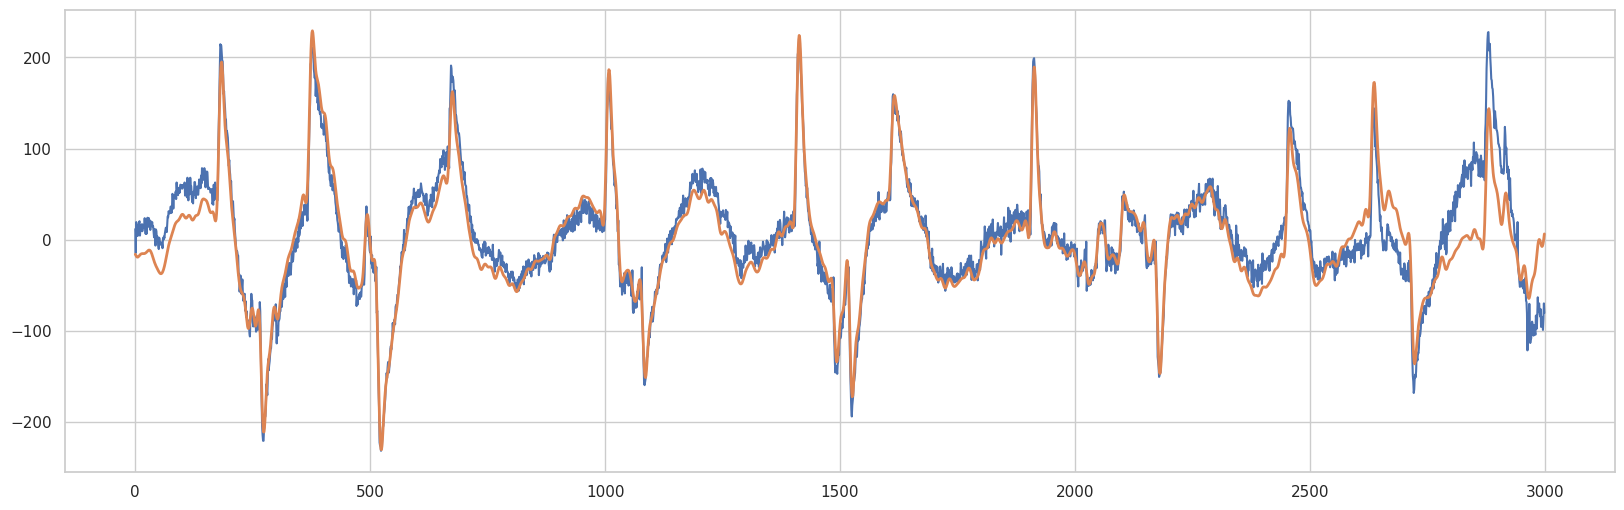

In [4]:
idx = 4

clean_data = ds_clean[idx][0].T
raw_data = ds_raw[idx][0].T

plt.figure(figsize=(20, 6))
plt.plot(raw_data[2])
plt.plot(clean_data[2], lw=2)
